# **Simulation Hedy 2025**

Team: TU Wien Space Team \
Project: Lamarr \
Rocket: Hedy \


## Installs

In this section all needed libraries are installed and the needed classes imported

In [2]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install rocketpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install CoolProp

Note: you may need to restart the kernel to use updated packages.


In [5]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, Fluid, LiquidMotor, CylindricalTank, MassFlowRateBasedTank, TrapezoidalFins, FreeFormFins, EllipticalFins, RailButtons, NoseCone, Tail, Parachute
import rocketpy as rpy
from math import exp
from math import pi
import datetime
import json
import CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI
from rocketpy.mathutils import Function

## Configuration (new)

Idea: a list of config dictionaries is passed to the simulation

Fetching elevation from open-elevation.com for lat=39.12368, lon=-8.03333...
Elevation received: 161.0 m
Nozzle Details
Nozzle Radius: 0.0375 m

Motor Details
Total Burning Time: 3.9999999999999996 s
Total Propellant Mass: 5.750 kg
Structural Mass Ratio: 0.000
Average Propellant Exhaust Velocity: 1818.182 m/s
Average Thrust: 2000.000 N
Maximum Thrust: 2000.0 N at 0.0 s after ignition.
Total Impulse: 8000.000 Ns



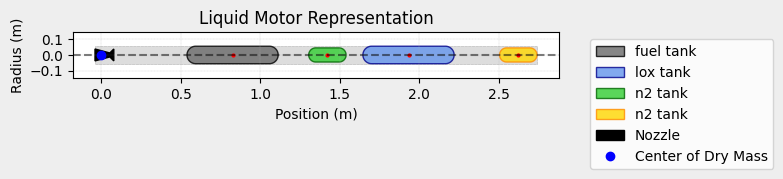

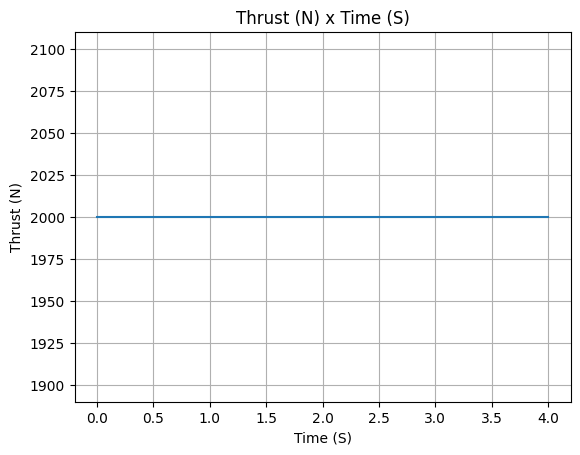

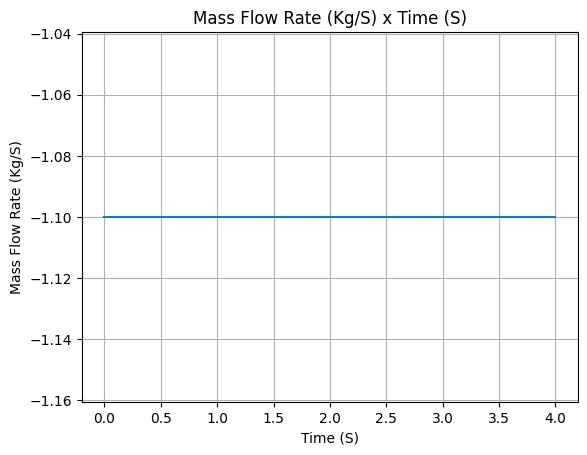

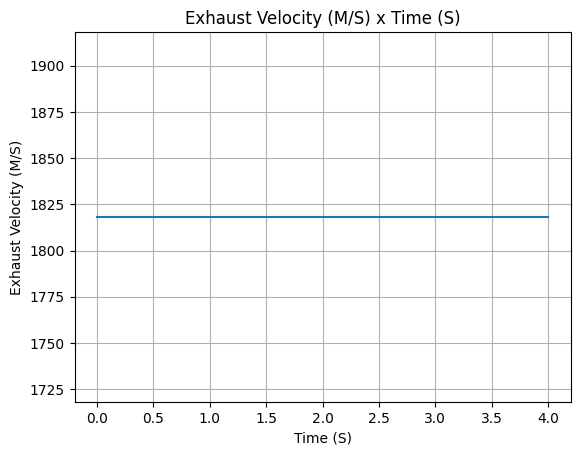

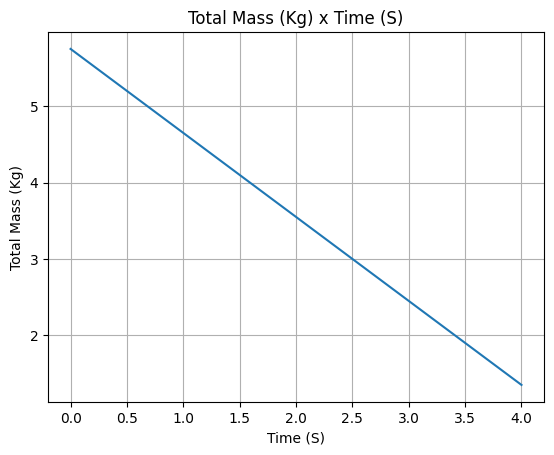

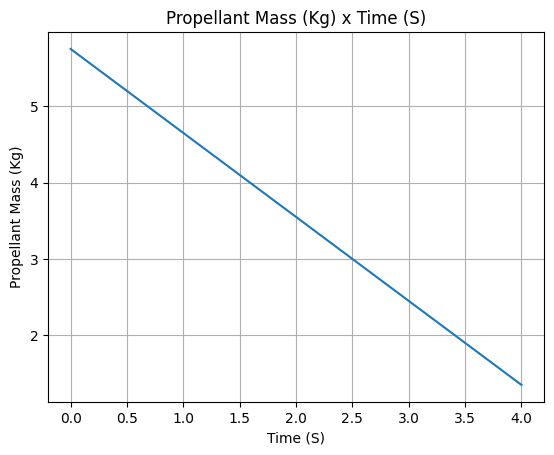

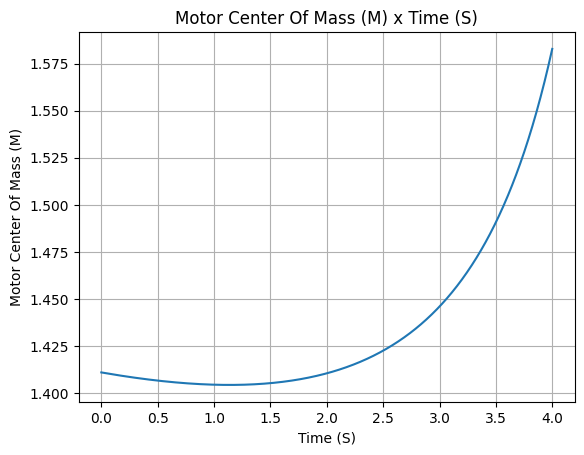

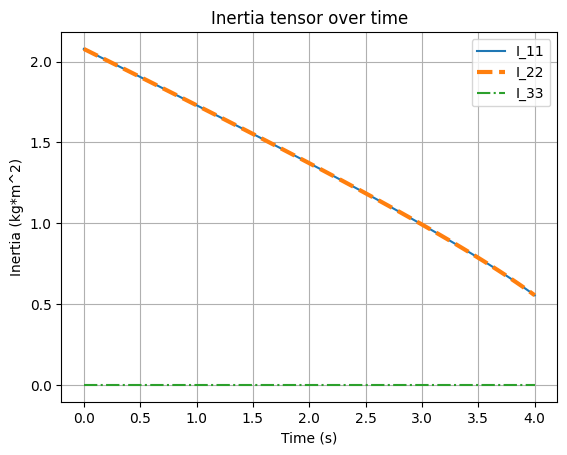

In [ ]:
# the file paths of all dictionaries to be simulated
config_dict_list = [
    "config_dict.json"
]

flight_dict = {}

for config in config_dict_list:
    # load the config json into a dictionary
    with open(config, "rt") as f:
        config_dict = json.loads(f.read())

    # flags initialisation
    # select whether preset mass from config sheet is used...
    use_preset_mass = config_dict["Flags"]["flag"]["use_preset_mass"]["Value"]
    # ...or highest geometrically possible mass is used
    # if both these flags are set to False, the mass is calculated through (massflow * burntime * (1 + overfill percentage))
    use_max_n2_mass = config_dict["Flags"]["flag"]["use_max_nitrogen_mass"]["Value"]
    use_max_mass = config_dict["Flags"]["flag"]["use_max_mass"]["Value"] # for fuel and lox
    # select whether thrust is a constant integer or a .csv file is provided
    use_static_thrust = config_dict["Flags"]["flag"]["use_static_thrust"]["Value"]
    # select whether the simulation adds ice weight to total rocket weight
    account_for_ice = config_dict["Flags"]["flag"]["account_for_ice"]["Value"]

    # check for valid flag selection (max and preset cannot be used simultaneously)
    if use_preset_mass and use_max_mass:
        print("Flag selection error")

    # Environment config // if environment should be with forecast, this code section must be adapted
    env = Environment()
    
    # convert from list to datetime -> ugly but it works
    date = datetime.datetime(
        int(config_dict["Environment"]["env"]["date"]["Value"][0]),
        int(config_dict["Environment"]["env"]["date"]["Value"][1]),
        int(config_dict["Environment"]["env"]["date"]["Value"][2]),
        int(config_dict["Environment"]["env"]["date"]["Value"][3]),
        int(config_dict["Environment"]["env"]["date"]["Value"][4]),
        int(config_dict["Environment"]["env"]["date"]["Value"][5])
        )
    
    env.set_location(
        latitude = config_dict["Environment"]["env"]["latitude"]["Value"],
        longitude = config_dict["Environment"]["env"]["longitude"]["Value"]
    )
    env.set_elevation("Open-Elevation")
    env.set_atmospheric_model(type = "standard_atmosphere")
    env.set_date(
        date,
        timezone = config_dict["Environment"]["env"]["timezone"]["Value"]
    )
    # end of environment section
    # Tanks config

    # preset initialisation
    t_burn = config_dict["Motor"]["presets"]["burn_time"]["Value"]
    t_holddown = config_dict["Motor"]["presets"]["holddown_time"]["Value"]

    if t_holddown > t_burn:
        print("Holddown time too long -> Time error")

    overfill_percentage = config_dict["Motor"]["presets"]["overfill_percentage"]["Value"]

    if use_static_thrust:
        thrust = lambda t: config_dict["Motor"]["presets"]["thrust"]["Value"]
    else:
        print("this feature is yet to be implemented")
    
    # geometrical initialisation
    length_n2_tank = config_dict["Motor"]["nitrogen_tank"]["length"]["Value"]
    length_fuel_tank = config_dict["Motor"]["ethanol_tank"]["length"]["Value"]
    length_lox_tank = config_dict["Motor"]["lox_tank"]["length"]["Value"]

    outer_diameter_n2_tank = config_dict["Motor"]["nitrogen_tank"]["outer_diameter"]["Value"]
    outer_diameter_fuel_tank = config_dict["Motor"]["ethanol_tank"]["outer_diameter"]["Value"]
    outer_diameter_lox_tank = config_dict["Motor"]["lox_tank"]["outer_diameter"]["Value"]

    thickness_n2_tank = config_dict["Motor"]["nitrogen_tank"]["thickness"]["Value"]
    thickness_fuel_tank = config_dict["Motor"]["ethanol_tank"]["thickness"]["Value"]
    thickness_lox_tank = config_dict["Motor"]["lox_tank"]["thickness"]["Value"]

    inner_diameter_n2_tank = outer_diameter_n2_tank - (2 * thickness_n2_tank)
    inner_diameter_fuel_tank = outer_diameter_fuel_tank - (2 * thickness_fuel_tank)
    inner_diameter_lox_tank = outer_diameter_lox_tank - (2 * thickness_lox_tank)

    n2_tank_shape = CylindricalTank(radius=(inner_diameter_n2_tank/2), height=length_n2_tank, spherical_caps=True)
    fuel_tank_shape = CylindricalTank(radius=(inner_diameter_fuel_tank/2), height=length_fuel_tank, spherical_caps=True)
    lox_tank_shape = CylindricalTank(radius=(inner_diameter_lox_tank/2), height=length_lox_tank, spherical_caps=True)

    nozzle_diameter = config_dict["Motor"]["nozzle"]["diameter"]["Value"]
    nozzle_position = config_dict["Motor"]["nozzle"]["position"]["Value"]

    # fluid dynamical initialisation
    massflow_n2 = config_dict["Motor"]["nitrogen_tank"]["massflow"]["Value"]
    massflow_fuel = config_dict["Motor"]["ethanol_tank"]["massflow"]["Value"]
    massflow_lox = config_dict["Motor"]["lox_tank"]["massflow"]["Value"]

    temperature_n2 = config_dict["Motor"]["presets"]["nitrogen_temperature"]["Value"]
    temperature_fuel = config_dict["Motor"]["presets"]["ethanol_temperature"]["Value"]
    temperature_lox = config_dict["Motor"]["presets"]["lox_temperature"]["Value"]

    pressure_n2 = config_dict["Motor"]["presets"]["nitrogen_pressure"]["Value"]
    pressure_fuel = config_dict["Motor"]["presets"]["ethanol_pressure"]["Value"]
    pressure_lox = config_dict["Motor"]["presets"]["lox_pressure"]["Value"]

    density_n2 = CP.PropsSI("D","T",temperature_n2,"P|gas",pressure_n2,"N2")
    density_fuel = CP.PropsSI("D", "T|liquid", temperature_fuel, "P", pressure_fuel, "ethanol")
    density_lox = CP.PropsSI("D", "T|liquid", temperature_lox, "P", pressure_lox, "oxygen")
    
    n2 = Fluid(name = "N2", density = density_n2)
    fuel = Fluid(name = "ethanol", density = density_fuel)
    lox = Fluid(name = "LOX", density = density_lox)

    # Mass flags processing
    # calculate mass that is passed on to RocketPy considering the selected flags
    if use_max_n2_mass:
        mass_n2 = n2_tank_shape.total_volume * density_n2
        # notify user if burn time is too long for available amount of n2 under given massflow
        if (mass_n2 / massflow_n2) < t_burn:
            print("Burntime too long or massflow too fast -> Nitrogen error")
    else:
        mass_n2 = massflow_n2 * t_burn * (1 + (overfill_percentage/100)) # if conversion from % is implemented in config generator -> remove /100
    
    if use_preset_mass:
        mass_fuel = config_dict["Motor"]["presets"]["ethanol_mass"]["Value"]
        mass_lox = config_dict["Motor"]["presets"]["lox_mass"]["Value"]
    elif use_max_mass:
        mass_fuel = fuel_tank_shape.total_volume * density_fuel
        mass_lox = lox_tank_shape.total_volume * density_fuel
        # if max values are used, burn time needs to be adjusted as this is now the variable
        if (mass_fuel / massflow_fuel) < (mass_lox / massflow_lox):
            t_burn = mass_fuel / massflow_fuel
        else:
            t_burn = mass_lox / massflow_lox
    else:
        mass_fuel = massflow_fuel * t_burn * (1 + (overfill_percentage/100))
        mass_lox = massflow_lox * t_burn * (1 + (overfill_percentage/100))

    # finally the burn time is updated to account for the holddown time; the mass which contributes to the flight is updated as well
    t_burn -= t_holddown
    mass_fuel -= massflow_fuel * t_holddown
    mass_lox -= massflow_lox * t_holddown

    # Mass flow rate tank model definitions
    n2_tank = MassFlowRateBasedTank(
        name="n2 tank",
        geometry=n2_tank_shape,
        flux_time=t_burn, # why is (mass_n2 / massflow_n2) used here in the original script?
        initial_liquid_mass=0,
        initial_gas_mass=mass_n2,
        liquid_mass_flow_rate_in=0,
        liquid_mass_flow_rate_out=0,
        gas_mass_flow_rate_in=0,
        gas_mass_flow_rate_out=lambda t: massflow_n2,
        liquid=Fluid(name="irrelevant", density=0.0001),
        gas=n2
    )
    
    fuel_tank = MassFlowRateBasedTank(
        name="fuel tank",
        geometry=fuel_tank_shape,
        flux_time=t_burn,
        initial_liquid_mass=mass_fuel,
        initial_gas_mass=0, # can be neglected
        liquid_mass_flow_rate_in=0,
        liquid_mass_flow_rate_out=lambda t: massflow_fuel,
        gas_mass_flow_rate_in=lambda t: massflow_n2,
        gas_mass_flow_rate_out=0,
        liquid=fuel,
        gas=n2
    )

    lox_tank = MassFlowRateBasedTank(
        name="lox tank",
        geometry=lox_tank_shape,
        flux_time=t_burn,
        initial_liquid_mass=mass_lox,
        initial_gas_mass = 0, # can be neglected
        liquid_mass_flow_rate_in=0,
        liquid_mass_flow_rate_out=lambda t: massflow_lox,
        gas_mass_flow_rate_in=lambda t: massflow_n2,
        gas_mass_flow_rate_out=0,
        liquid=lox,
        gas = n2
    )

    propulsion_system = LiquidMotor(
        dry_mass=0.0001,
        dry_inertia=(0,0,0),
        center_of_dry_mass_position=0,
        nozzle_radius=(nozzle_diameter/2),
        nozzle_position=nozzle_position,
        thrust_source=thrust,
        burn_time=t_burn,
        coordinate_system_orientation="nozzle_to_combustion_chamber"
    )

    propulsion_system.add_tank(tank=fuel_tank, position=config_dict["Motor"]["ethanol_tank"]["CG"]["Value"])
    propulsion_system.add_tank(tank=lox_tank, position=config_dict["Motor"]["lox_tank"]["CG"]["Value"])
    propulsion_system.add_tank(tank=n2_tank, position=config_dict["Motor"]["nitrogen_tank"]["CG_ethanol"]["Value"])
    propulsion_system.add_tank(tank=n2_tank, position=config_dict["Motor"]["nitrogen_tank"]["CG_lox"]["Value"])

    #propulsion_system.all_info()
    

    



## Configuration

The length unit chosen here is millimeters to keep the values more readable. If necessary, values should be converted accordingly.

In [18]:
# Rocket configuration data
env_config = {
    "date" : (2025, 2, 17, 13, 00, 00),   # yyyy, mm, dd, hh, mm, ss
    "latitude" : 39.12368,                # Launch latitude    #Preset
    "longitude" : -8.03333,               # Launch longitude   #Preset
    "timezone" : "Europe/Lisbon"          # GMT+1   #Preset
}
motor_config = {
    "burn_time" : 5.1,                      # s       #calculated
    "holddown_time" : 1.1,                # s       #calculated

    "nitrogen_tank" : {
        "length" : 235.411,               # mm
        "CG_lox" : 2622.95,               # mm
        "CG_ethanol" : 1422.1595,         # mm
        "outer_diameter": 93,             # mm
        "thickness" : 2,                  # mm
        "massflow" : 0.03,                # kg/s   #Estimate
    },
    "ethanol_tank" : {
        "length" : 573.61485,             # mm
        "CG" : 825.55,                    # mm
        "outer_diameter": 115,            # mm
        "thickness" : 2.5,                # mm
        "massflow" : 0.5,                 # kg/s   #tested
    },
    "lox_tank" : {
        "length" : 573.978,               # mm
        "CG" : 1932.5205,                 # mm
        "outer_diameter" : 115,           # mm
        "thickness" : 2.5,                # mm
        "massflow" : 0.6,                 # kg/s   #tested
    },
    "nozzle" : {
        "diameter" : 75,                  # mm
        "position" : -40,                 # mm
    },


    "use_preset_ethanol_mass" : False,
    "use_preset_lox_mass" : False,
    "use_max_nitrogen_mass" : True,
    "use_max_ethanol_mass" : True,
    "use_max_lox_mass" : True,
    "use_static_thrust": True,
    "thrust": 2000,                       #N
    "overfill_percentage" : 0.001,        # %       #Preset

    "mass" : {
      "ethanol" : 2.7,                    # kg     #Preset
      "lox" : 3.5,                        # kg     #Preset
      "ice" : 0.5                         # kg     #Preset
    },
    "temperature" : {
        "ethanol" : 298.15,               # K      #Preset (= 25°C)
        "lox" : 73.15,                    # K      #Preset (= -200°C)
        "nitrogen" : 298.15             # K      #Preset (= 25°C)
    },
    "pressure" : {
        "ethanol" : 3000000,              # Pa     #Preset
        "lox" : 3000000,                  # Pa     #Preset
        "nitrogen" : 30000000           # Pa     #Preset
    }
}

rocket_config = {
    "account_for_ice" : True,
    "total_weight" : 16580,               # g       #weighed
    "total_length" : 3765,                # mm
    "total_CG" : 1813,                    # mm      #calculated
    "moment_of_intertia_Z" : 0.0255,      # kg*m^2  #calculated
    "moment_of_intertia_XY" : 16.8,       # kg*m^2  #calculated
    "nosecone_length" : 650,              # mm
    "railbuttons" : {
        "upper" : 1646.67,                # mm
        "lower" : 297.5,                  # mm
    },
    "tailcone" : {
        "diameter" : 97.8,                # mm
        "length" : 245.643,               # mm
        "cylindrical_height" : 34.8,      # mm
    },
    "rocket" : {
        "thickness" : 1.4,                # mm
        "diameter" : 132.8,               # mm
    },
    "fins" : {
        "name" : "Biconvex",
        "amount" : 4,
        "root_chord" : 199.0211,          # mm
        "tip_chord" : 79.4,               # mm
        "span" : 96.4,                    # mm
        "sweep_length" : 63.892,          # mm
        "position" : 233,                 # mm
        "shape_points" : ((0,0),
                          (-0.0265,0.0036),
                          (-0.0902,0.114),
                          (-0.170,0.114),
                          (-0.234,0.017),
                          (-0.0265,0.00359),
                          (0,0))
    },
    "parachutes" : {
        "main" : {
            "cd_s" : 6.911503837897546,
            "trigger" : 450,              # m      #Preset
            "sampling_rate" : 105,        # hz     #Preset
            "lag" : 4,                    # s      #Tested
            "noise" : (0, 8.3, 0.5)       # (pa, pa, pa)
        },
        "drogue" : {
            "cd_s" : 0.336875,
            "trigger" : "apogee",         # m      #Preset
            "sampling_rate" : 105,        # hz     #Preset
            "lag" : 1,                    # s      #tested
            "noise" : (0, 8.3, 0.5)       # (pa, pa, pa)
        }
    }
}
flight_config = {
    "rail_length" : 11,                   # m       #Preset
    "inclination" : 84,                   # °       #Preset
    "heading" : 133,                      # °       #Preset
}

## Environments Initialization




In this Section the environments are initialized.
*   **envForecast**: environment with the weather data from the wyoming-sounding data source at the location and date of EuRoc
*   **envNormal**: normalized environment with standard atmospheric values at the time and location of EuRoc
*   **envCostom**: custom environment with variable values for temperature and windspeed


In [ ]:
#Ponte de Sor: 39.12368, -8.03333
#EUROC: 09.-15.10.2024
#possible launch date: 11.10.2024

#Environment based on Forecast data for the EuRoC 2024
envForecast = Environment()

envForecast.set_location(latitude = env_config["latitude"], longitude = env_config["longitude"])
envForecast.set_elevation("Open-Elevation")
envForecast.set_date(
    env_config["date"],
    timezone = env_config["timezone"]
)

envForecast.set_atmospheric_model(type="Forecast", file="GFS")
envForecast.info()


#Environment based on standard values
envNormal = Environment()
envNormal.set_location(latitude = env_config["latitude"], longitude = env_config["longitude"])
envNormal.set_elevation("Open-Elevation")
envNormal.set_date(env_config["date"], timezone = env_config["timezone"])
envNormal.set_atmospheric_model(type = "standard_atmosphere")
envNormal.info()

#Environment based on Custom Data
envCustom = Environment()
envCustom.set_location(latitude = env_config["latitude"], longitude = env_config["longitude"])
envCustom.set_atmospheric_model(type = "custom_atmosphere", temperature = 30 + 273.15, wind_u = lambda t:10 + (t /1000)**2, wind_v = 0)
envCustom.info()

## Simulation

### Tanks / Engine



In [ ]:
#Burn time
t_burn              = motor_config["burn_time"]       #s
#holddown time
t_holddown          = motor_config["holddown_time"]   #s


# tank height
h_nitrogen_tank     = motor_config["nitrogen_tank"]["length"]     / 1000  #m
h_ethanol_tank      = motor_config["ethanol_tank"]["length"]      / 1000  #m
h_lox_tank          = motor_config["lox_tank"]["length"]          / 1000  #m
#OuterDiameter
OD_nitrogen_tank    = motor_config["nitrogen_tank"]["outer_diameter"]   / 1000  #m
OD_ethanol_tank     = motor_config["ethanol_tank"]["outer_diameter"]    / 1000  #m
OD_lox_tank         = motor_config["lox_tank"]["outer_diameter"]        / 1000  #m
#Thickness
Th_nitrogen_tank    = motor_config["nitrogen_tank"]["thickness"]  / 1000  #m
Th_ethanol_tank     = motor_config["ethanol_tank"]["thickness"]   / 1000  #m
Th_lox_tank         = motor_config["lox_tank"]["thickness"]       / 1000  #m
#massflows
mdot_nitrogen     = motor_config["nitrogen_tank"] ["massflow"]    #kg/s
mdot_ethanol      = motor_config["ethanol_tank"]["massflow"]      #kg/s
mdot_lox          = motor_config["lox_tank"]["massflow"]          #kg/s
#nozzle
nozzle_diameter     = motor_config["nozzle"]["diameter"]          / 1000  #m
nozzle_position     = motor_config["nozzle"]["position"]          / 1000  #m


#preset mass flag
use_preset_ethanol_mass   = motor_config["use_preset_ethanol_mass"]
use_preset_lox_mass       = motor_config["use_preset_lox_mass"]
#max mass flag
use_max_nitrogen_mass   = motor_config["use_max_nitrogen_mass"]
use_max_ethanol_mass    = motor_config["use_max_ethanol_mass"]
use_max_lox_mass        = motor_config["use_max_lox_mass"]
#static thrust flag
use_static_thrust   = motor_config["use_static_thrust"]
#thrust
thrust              = motor_config["thrust"]                          #N
#Overfill
overfill_percentage = motor_config["overfill_percentage"]             #%


#masses
m_ethanol_preset    = motor_config["mass"]["ethanol"]                 #kg
m_lox_preset        = motor_config["mass"]["lox"]                     #kg
# Temperature Lox & Ethanol
T_nitrogen        = motor_config["temperature"]["nitrogen"]           #K  (=25°C)
T_ethanol         = motor_config["temperature"]["ethanol"]            #K  (=25°C)
T_lox             = motor_config["temperature"]["lox"]                #K
# pressure LOX & Ethanol
p_nitrogen        = motor_config["pressure"]["nitrogen"]              #Pa
p_ethanol         = motor_config["pressure"]["ethanol"]               #Pa
p_lox             = motor_config["pressure"]["lox"]                   #Pa









# inner diameter
ID_nitrogen_tank = OD_nitrogen_tank - (2* Th_nitrogen_tank)     # m
ID_ethanol_tank = OD_ethanol_tank - (2 * Th_ethanol_tank)       # m
ID_lox_tank = OD_lox_tank - (2 * Th_lox_tank)                   # m

# Propellants
# mass
m_nitrogen_calculated = mdot_nitrogen * (t_burn)                # kg
m_ethanol_calculated = mdot_ethanol * (t_burn)                  # kg
m_lox_calculated = mdot_lox * (t_burn)                          # kg

# define density
rho_nitrogen = CP.PropsSI("D","T",T_nitrogen,"P|gas",p_nitrogen,"N2")             # kg/m^3
rho_ethanol = CP.PropsSI("D", "T|liquid", T_ethanol, "P", p_ethanol, "ethanol")   # kg/m^3
rho_lox = CP.PropsSI("D", "T|liquid", T_lox, "P", p_lox, "oxygen")                # kg/m^3

# define fluids
nitrogen = Fluid(name = "N2", density = rho_nitrogen)
ethanol = Fluid(name = "ethanol", density = rho_ethanol)
lox = Fluid(name = "LOX", density = rho_lox)

# define tanks geometry
nitrogen_tank_shape = CylindricalTank(radius = ID_nitrogen_tank / 2, height = h_nitrogen_tank, spherical_caps = True)
ethanol_tank_shape = CylindricalTank(radius = ID_ethanol_tank / 2, height = h_ethanol_tank, spherical_caps = True)
lox_tank_shape = CylindricalTank(radius = ID_lox_tank / 2, height = h_lox_tank, spherical_caps = True)




v_nitrogen_tank = nitrogen_tank_shape.volume(h_nitrogen_tank/2)   # m³
v_ethanol_tank = ethanol_tank_shape.volume(h_ethanol_tank/2)      # m³
v_lox_tank = lox_tank_shape.volume(h_lox_tank/2)                  # m³

m_nitrogen_max = v_nitrogen_tank * rho_nitrogen                   # m
m_ethanol_max = v_ethanol_tank * rho_ethanol                      # m
m_lox_max = v_lox_tank * rho_lox                                  # m

t_burn_nitrogen = (m_nitrogen_max / mdot_nitrogen)-0.001          # s


if(use_max_ethanol_mass and use_preset_ethanol_mass):
  print("Cannot use preset and max!")
  m_enthanol = 100/0

if(use_max_lox_mass and use_preset_lox_mass):
  print("Cannot use preset and max!")
  m_lox = 100/0



if(use_max_nitrogen_mass):
  m_nitrogen = m_nitrogen_max
else:
  m_nitrogen = m_nitrogen_calculated + (overfill_percentage/100 * t_burn * mdot_nitrogen)

if(use_preset_ethanol_mass):
  m_ethanol = m_ethanol_preset
elif(use_max_ethanol_mass):
  m_ethanol = m_ethanol_max
else:
  m_ethanol = m_ethanol_calculated + (overfill_percentage/100 * t_burn * mdot_ethanol)

if(use_preset_lox_mass):
  m_lox = m_lox_preset
elif(use_max_lox_mass):
  m_lox = m_lox_max
else:
  m_lox = m_lox_calculated + (overfill_percentage/100 * t_burn * mdot_lox)

if(use_max_ethanol_mass and use_max_lox_mass):
  t_burn_ethanol = (m_ethanol_max / mdot_ethanol)
  t_burn_lox = (m_lox_max / mdot_lox)
  if(t_burn_ethanol<t_burn_lox):
    t_burn = t_burn_ethanol-0.001
  else:
    t_burn = t_burn_lox-0.001

if(use_static_thrust):
  thrust_curve = lambda t: thrust
else:
  thrust_curve = "thrust_curve.csv"

#account for holddown
t_burn -= t_holddown
m_lox -= mdot_lox * t_holddown
m_ethanol -= mdot_ethanol * t_holddown

if(t_burn_nitrogen<t_burn):
  print("WARNING: TOO LITTLE NITROGEN, UNKNOWN EFFECTS")


# define tanks
nitrogen_tank = MassFlowRateBasedTank(
    name = "nitrogen tank",
    geometry = nitrogen_tank_shape,
    flux_time = t_burn_nitrogen,                        # s
    initial_liquid_mass = 0,                            # kg
    initial_gas_mass = m_nitrogen,                      # kg
    liquid_mass_flow_rate_in = 0,                       # kg/s
    liquid_mass_flow_rate_out = 0,                      # kg/s
    gas_mass_flow_rate_in = 0,                          # kg/s
    gas_mass_flow_rate_out = lambda t: mdot_nitrogen,   # ks/s
    liquid = Fluid(name = "liquid", density = 0.0001),  # ignore
    gas = nitrogen,
)
ethanol_tank = MassFlowRateBasedTank(
    name = "fuel tank",
    geometry = ethanol_tank_shape,
    flux_time = t_burn,                                 # s
    initial_liquid_mass = m_ethanol,                    # kg
    initial_gas_mass = 0,                               # kg
    liquid_mass_flow_rate_in = 0,                       # kg/s
    liquid_mass_flow_rate_out = lambda t: mdot_ethanol, # kg/s
    gas_mass_flow_rate_in = lambda t: mdot_nitrogen,    # kg/s
    gas_mass_flow_rate_out = 0,                         # kg/s
    liquid = ethanol,
    gas = nitrogen,
)

lox_tank = MassFlowRateBasedTank(
    name = "oxidizer tank",
    geometry = lox_tank_shape,
    flux_time = t_burn,                                 # s
    initial_liquid_mass = m_lox,                        # kg
    initial_gas_mass = 0,                               # kg
    liquid_mass_flow_rate_in = 0,                       # kg/s
    liquid_mass_flow_rate_out = lambda t: mdot_lox,     # kg/s
    gas_mass_flow_rate_in = lambda t: mdot_nitrogen,    # kg/s
    gas_mass_flow_rate_out = 0,                         # kg/s
    liquid = lox,
    gas = nitrogen,
)

skuld = LiquidMotor(
    dry_mass = 0.0001,                  # kg
    dry_inertia = (0,0,0),              # kg*m^2
    center_of_dry_mass_position = 0,    # m

    nozzle_radius = nozzle_diameter /2, # m
    nozzle_position = nozzle_position,  # m

    thrust_source = thrust_curve,       # N
    burn_time = t_burn,                 # s
    coordinate_system_orientation = "nozzle_to_combustion_chamber"
)

skuld.add_tank(tank = lox_tank, position =        motor_config["lox_tank"]["CG"]                /1000)
skuld.add_tank(tank = ethanol_tank, position =    motor_config["ethanol_tank"]["CG"]            /1000)
skuld.add_tank(tank = nitrogen_tank, position =   motor_config["nitrogen_tank"]["CG_lox"]       /1000)
skuld.add_tank(tank = nitrogen_tank, position =   motor_config["nitrogen_tank"]["CG_ethanol"]   /1000)

skuld.all_info()

### Rocket components

In [ ]:
#rocket
rocket_length     = rocket_config["total_length"]         / 1000  #m
rocket_diameter   = rocket_config["rocket"]["diameter"]   / 1000  #m
rocket_thickness  = rocket_config["rocket"]["thickness"]  / 1000  #m

nose_cone = NoseCone(
    length = (rocket_config["nosecone_length"]-100)/1000, # m
    base_radius = rocket_diameter/2,                      # m
    kind = "lv haack"
)

tailcone_cylindrical    = rocket_config["tailcone"]["cylindrical_height"] / 1000 # m
tailcone_length         = rocket_config["tailcone"]["length"]             / 1000 # m
tailcone_bottom_radius  = rocket_config["tailcone"]["diameter"]        /2 / 1000 # m

tail = Tail(
    top_radius = rocket_diameter /2,        # m
    bottom_radius = tailcone_bottom_radius, # m
    length = tailcone_length,               # m
    rocket_radius = rocket_diameter/2       # m
)

fin_amount        = rocket_config["fins"]["amount"]
fin_name          = rocket_config["fins"]["name"]
fin_position      = rocket_config["fins"]["position"]     / 1000  # m
fin_root_chord    = rocket_config["fins"]["root_chord"]   / 1000  # m
fin_tip_chord     = rocket_config["fins"]["tip_chord"]    / 1000  # m
fin_span          = rocket_config["fins"]["span"]         / 1000  # m
fin_sweep_length  = rocket_config["fins"]["sweep_length"] / 1000  # m
fin_shape_points  = rocket_config["fins"]["shape_points"]

trapezoidal_fin_set = TrapezoidalFins(
    n = fin_amount,
    root_chord = fin_root_chord,      # m
    tip_chord = fin_tip_chord,        # m
    span = fin_span,                  # m
    sweep_length = fin_sweep_length,  # m
    #cant_angle = fin_cant_angle,     # deg
    #sweep_angle = fin_sweep_angle,   # deg
    name = fin_name,
    rocket_radius = rocket_diameter/2 # m
  )
trapezoidal_fin_set.draw()

fin_set = FreeFormFins(
   n = fin_amount,
   shape_points = fin_shape_points,
   rocket_radius=tailcone_bottom_radius,
   name = "Freeform"
)
fin_set.draw()

parachutes = {}

parachutes[0] = Parachute(
    name = "main",
    cd_s = rocket_config["parachutes"]["main"]["cd_s"],
    trigger = rocket_config["parachutes"]["main"]["trigger"],             # m
    sampling_rate = rocket_config["parachutes"]["main"]["sampling_rate"], # hz
    lag = rocket_config["parachutes"]["main"]["lag"],                     # s
    noise = rocket_config["parachutes"]["main"]["noise"],                 # (pa, pa, pa)
)

parachutes[1] = Parachute(
    name = "drogue",
    cd_s = rocket_config["parachutes"]["drogue"]["cd_s"],
    trigger = rocket_config["parachutes"]["drogue"]["trigger"],             # m
    sampling_rate = rocket_config["parachutes"]["drogue"]["sampling_rate"], # hz
    lag = rocket_config["parachutes"]["drogue"]["lag"],                     # s
    noise = rocket_config["parachutes"]["drogue"]["noise"],                 # (pa, pa, pa)
)

### Hedy

In [ ]:

total_mass        = rocket_config["total_weight"]         / 1000  # kg

if rocket_config["account_for_ice"]:
  total_mass += motor_config["mass"]["ice"]

#inertia
inertia_x_y   = rocket_config["moment_of_intertia_XY"]          # kg/m^2
inertia_z     = rocket_config["moment_of_intertia_Z"]           # kg/m^2

upper_railbutton_position = rocket_config["railbuttons"]["upper"]/1000
lower_railbutton_position = rocket_config["railbuttons"]["lower"]/1000

#CG
CG                = rocket_config["total_CG"]             / 1000  # m

hedy = Rocket(
    radius = rocket_diameter /2,                      # m
    mass = total_mass,                                # m
    inertia = (inertia_x_y, inertia_x_y, inertia_z),  # kg * m^2
    power_off_drag = "power_off_drag.csv",
    power_on_drag = "power_on_drag.csv",
    center_of_mass_without_motor = CG,                # m
    coordinate_system_orientation = "tail_to_nose"
)
hedy.add_motor(skuld, position = 0)


#hedy.set_rail_buttons(upper_button_position= upper_railbutton_position, lower_button_position=lower_railbutton_position)

hedy.add_surfaces(surfaces=[nose_cone, trapezoidal_fin_set, tail], positions=[rocket_length, 0, tailcone_length])

hedy.parachutes = list(parachutes.values())

hedy.all_info()

### Flight

In [ ]:
from os import name

#flight = Flight(
#          environment = envNormal,
#          rocket = hedy,
#          rail_length =   flight_config["rail_length"], # m
#          inclination =   flight_config["inclination"], # °
#          heading =       flight_config["heading"],     # °
#          terminate_on_apogee = True,
#          name = "Normal"
#  )
#flight.prints.out_of_rail_conditions()
#flight.prints.apogee_conditions()
#flight.prints.impact_conditions()
#flight.prints.maximum_values()
#flight.plots.trajectory_3d()
#flight.plots.stability_and_control_data()
#flight.plots.all()

#flight.prints.all()
#flight.all_info()



flight_forecast = Flight(
          environment = envForecast,
          rocket = hedy,
          rail_length =   flight_config["rail_length"], # m
          inclination =   flight_config["inclination"], # °
          heading =       flight_config["heading"],     # °
          name = "Forecast"
  )
#flight_forecast.prints.out_of_rail_conditions()
#flight_forecast.prints.apogee_conditions()
#flight_forecast.prints.impact_conditions()
#flight_forecast.prints.maximum_values()
#flight_forecast.plots.trajectory_3d()
#flight_forecast.plots.stability_and_control_data()
flight_forecast.all_info()


In [ ]:
# Helper class
from rocketpy import Function
import copy

# Prepare a copy of the rocket
hedy2 = copy.deepcopy(hedy)
hedy2.motor.positioned_tanks.pop(-4)
hedy2.motor.positioned_tanks.pop(-3)



# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [0.7]:
    # Modify rocket fin set by removing previous one and adding new one

    lox_tank2 = lox_tank
    lox_tank2.liquid_mass_flow_rate_out = 0.3

    ethanol_tank2 = ethanol_tank
    ethanol_tank2.liquid_mass_flow_rate_out = 0.3
    skuld2 = LiquidMotor(
        dry_mass = skuld.dry_mass,                  # kg
        dry_inertia = (skuld.dry_I_11, skuld.dry_I_22, skuld.dry_I_33),              # kg*m^2
        center_of_dry_mass_position = skuld.center_of_dry_mass_position,    # m

        nozzle_radius = skuld.nozzle_radius, # m
        nozzle_position = skuld.nozzle_position,  # m

        thrust_source = skuld.thrust_source,       # N
        burn_time = skuld.burn_time,                 # s
        coordinate_system_orientation = skuld.coordinate_system_orientation
    )
    skuld2.add_tank(tank = lox_tank2,   	position =   motor_config["lox_tank"]["CG"]                /1000)
    skuld2.add_tank(tank = ethanol_tank2, position =   motor_config["ethanol_tank"]["CG"]            /1000)
    skuld2.add_tank(tank = nitrogen_tank, position =   motor_config["nitrogen_tank"]["CG_lox"]       /1000)
    skuld2.add_tank(tank = nitrogen_tank, position =   motor_config["nitrogen_tank"]["CG_ethanol"]   /1000)

    hedy2.add_motor(skuld2, position = 0)
    # Simulate
    test_flight = Flight(
        rocket=hedy2,
        environment=envForecast,
        rail_length=5.2,
        inclination=90,
        heading=0
    )

    test_flight.prints.apogee_conditions()
    # Store Results
    static_margin_at_ignition = hedy2.static_margin(0)
    static_margin_at_out_of_rail = hedy2.static_margin(test_flight.out_of_rail_time)
    static_margin_at_steady_state = hedy2.static_margin(test_flight.t_final)
    simulation_results += [
        (
            test_flight.attitude_angle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                static_margin_at_ignition,
                static_margin_at_out_of_rail,
                static_margin_at_steady_state,
            ),
        )
    ]

Function.compare_plots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

# **Stochastic Calculations (Monte Carlo)**


## Imports

In [ ]:
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticSolidMotor,
    StochasticRocket,
    StochasticFlight,
    StochasticNoseCone,
    StochasticTail,
    StochasticTrapezoidalFins,
    StochasticParachute,
    StochasticRailButtons,
)
from rocketpy import MonteCarlo
from rocketpy import Components

## Stochastic environment

In [ ]:
envEnsemble = Environment()
envEnsemble.set_location(latitude = env_config["latitude"], longitude = env_config["longitude"])
envEnsemble.set_elevation("Open-Elevation")
envEnsemble.set_date((env_config["date"]), timezone= env_config["timezone"]) #Latest available date at time of simualtion
envEnsemble.set_atmospheric_model(type = "Ensemble", file = "GEFS")


stochastic_env = StochasticEnvironment(
    environment = envEnsemble,
    wind_velocity_x_factor = (0, 10, "normal"),
    wind_velocity_y_factor = (0, 10, "normal"),

    ensemble_member = list(range(envEnsemble.num_ensemble_members)),
)
stochastic_env.visualize_attributes()

Fetching elevation from open-elevation.com for lat=39.12368, lon=-8.03333...
Elevation received: 161.0 m


/usr/local/lib/python3.10/dist-packages/rocketpy/environment/tools.py:309: UserWarning: Exact chosen launch time is not available in the provided file, using 2024-10-11 12:00:00 UTC instead.
  warnings.warn(


Reporting the attributes of the `StochasticEnvironment` object:

Constant Attributes:
	datum                    SIRGAS2000
	elevation                161.0
	gravity                  Function from R1 to R1 : (height (m)) → (gravity (m/s²))
	latitude                 39.12368
	longitude                -8.03333
	timezone                 Europe/Lisbon

Stochastic Attributes:
	wind_velocity_x_factor   0.00000 ± 10.00000 (normal)
	wind_velocity_y_factor   0.00000 ± 10.00000 (normal)

Stochastic Attributes with choice of values:
	ensemble_member [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


## Approximating the liquid motor

In [ ]:
grain_outer_radius = 0.05  # m
grain_inner_radius = 0.01  # m
grain_height = 0.1         # m

approx_motor = SolidMotor(
    thrust_source = skuld.thrust_source,
    burn_time = skuld.burn_time,          # s
    center_of_dry_mass_position = 0,      # m
    dry_mass = skuld.dry_mass,            # kg
    dry_inertia = [0, 0, 0],              # kg * m^2
    grains_center_of_mass_position = CG,  # m
    grain_number = 1,
    grain_density = (lox_tank.fluid_mass(0) + ethanol_tank.fluid_mass(0)) / (((grain_outer_radius**2) * pi * grain_height) - ((grain_inner_radius**2) * pi * grain_height)), # kg / m^3
    grain_outer_radius = grain_outer_radius,         # m
    grain_initial_inner_radius = grain_inner_radius, # m
    grain_initial_height = grain_height,             # m
    grain_separation = 0,                     # m
    nozzle_radius = skuld.nozzle_radius,      # m
    nozzle_position = skuld.nozzle_position,  # m
    throat_radius = skuld.nozzle_radius,      # m
    reshape_thrust_curve = False,
    coordinate_system_orientation = 'nozzle_to_combustion_chamber',
)
#approx_motor.all_info()

## Stochastic rocket

In [ ]:
railbuttons = RailButtons(
    buttons_distance = upper_railbutton_position-lower_railbutton_position
)

In [ ]:
hedy.aerodynamic_surfaces = Components()
hedy.add_surfaces(surfaces=[nose_cone, trapezoidal_fin_set, tail], positions=[rocket_length, fin_position, tailcone_length])

stochastic_rocket = StochasticRocket(
    rocket = hedy,
)

stochastic_nose_cone = StochasticNoseCone(
    nosecone = nose_cone
)

stochastic_fin_set = StochasticTrapezoidalFins(
    trapezoidal_fins = trapezoidal_fin_set,
)

stochastic_tail = StochasticTail(
    tail = tail
)

stochastic_rail_buttons = StochasticRailButtons(
    rail_buttons = railbuttons
)

stochastic_main = StochasticParachute(
    parachute = parachutes[0]
)

stochastic_drogue = StochasticParachute(
    parachute = parachutes[1]
)

stochastic_motor = StochasticSolidMotor(
    solid_motor = approx_motor
)

stochastic_rocket.add_nose(stochastic_nose_cone)
stochastic_rocket.add_trapezoidal_fins(stochastic_fin_set)
stochastic_rocket.add_tail(stochastic_tail)
stochastic_rocket.add_parachute(stochastic_main)
stochastic_rocket.add_parachute(stochastic_drogue)
stochastic_rocket.add_motor(stochastic_motor)

stochastic_rocket.visualize_attributes()


stochastic_flight = StochasticFlight(
    flight = flight,
    inclination=(flight_config["inclination"], 1),
    heading=(flight_config["heading"], 2)
)

stochastic_flight.visualize_attributes()



test_dispersion = MonteCarlo(
    filename = "monte_carlo_class_example",
    environment = stochastic_env,
    rocket = stochastic_rocket,
    flight = stochastic_flight
)

Reporting the attributes of the `StochasticRocket` object:

Constant Attributes:
	I_11_without_motor              16.8
	I_12_without_motor              0
	I_13_without_motor              0
	I_22_without_motor              16.8
	I_23_without_motor              0
	I_33_without_motor              0.0255
	center_of_mass_without_motor    1.813
	coordinate_system_orientation   tail_to_nose
	mass                            16.22207571
	power_off_drag                  Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)
	power_on_drag                   Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)
	radius                          0.0664

Stochastic Attributes:
	power_off_drag_factor           1.00000 ± 0.00000 (normal)
	power_on_drag_factor            1.00000 ± 0.00000 (normal)
Reporting the attributes of the `StochasticFlight` object:

Constant Attributes:
	rail_length           11

Stochastic Attributes:
	heading               113.00000 ± 2.0

## Simulation

In [ ]:
test_dispersion.simulate(number_of_simulations = 100, append = False)

print()
print()
print()
print()
print()
print()
print()
print()
print("//////////////////////////////////////////////////")
print("//                 FINISHED                     //")
print("//////////////////////////////////////////////////")

Error on iteration 1: Object of type Vector is not JSON serializable


TypeError: Object of type Vector is not JSON serializable

## Outputs

In [ ]:
print(test_dispersion.num_of_loaded_sims)
test_dispersion.prints.all()
test_dispersion.plots.ellipses(xlim = (-2000, 4000), ylim = (-2000, 4000))